__Chapter 15 - Classifying Images with Deep Convolutional Neural Networks__

1. [Building blocks of convolutional neural networks](#Building-blocks-of-convolutional-neural-networks)
    1. [Understanding CNNs and learning feature hierarchies](#Understanding-CNNs-and-learning-feature-hierarchies)
    1. [Performing discrete convolutions in one dimension](#Performing-discrete-convolutions-in-one-dimension)
    1. [The effect of zero-padding in a convolution](#The-effect-of-zero-padding-in-a-convolution)
    1. [Determining the size of the convolution output](#Determining-the-size-of-the-convolution-output)
1. [Performing a discrete convolution in 2D](#Performing-a-discrete-convolution-in-2D)
1. [Subsampling](#Subsampling)
1. [Putting everything together to build a CNN](#Putting-everything-together-to-build-a-CNN)
    1. [Working with multiple input or color channels](#Working-with-multiple-input-or-color-channels)
    1. [Regularizing a neural network with dropout](#Regularizing-a-neural-network-with-dropout)
1. [Implementing a deep convolutional neural network using TensorFlow](#Implementing-a-deep-convolutional-neural-network-using-TensorFlow)
    1. [The multilayer CNN architecture](#The-multilayer-CNN-architecture)
    1. [Loading and prepreocessing the data](#Loading-and-prepreocessing-the-data)
1. [Implementing a CNN in the TensorFlow low-level API](#Implementing-a-CNN-in-the-TensorFlow-low-level-API)
1. [Implementing a CNN in the TensorFlow Layers API](#Implementing-a-CNN-in-the-TensorFlow-Layers-API)
1. [](#)
1. [](#)
1. [](#)
1. [](#)
1. [](#)
1. [](#)




In [1]:
# Standard libary and settings
import os
import sys
import importlib
import itertools
import warnings; warnings.simplefilter('ignore')
dataPath = os.path.abspath(os.path.join('../../Data'))
modulePath = os.path.abspath(os.path.join('../../CustomModules'))
sys.path.append(modulePath) if modulePath not in sys.path else None
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:95% !important; }</style>"))


# Data extensions and settings
import numpy as np
np.set_printoptions(threshold = np.inf, suppress = True)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.6f}'.format


# Modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.utils as utils


# Visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt


# Custom extensions and settings
from quickplot import qp, qpUtil, qpStyle
from mlTools import powerGridSearch
sns.set(rc = qpStyle.rcGrey)


# Magic functions
%matplotlib inline


<a id = 'Building-blocks-of-convolutional-neural-networks'></a>

# Building blocks of convolutional neural networks

Convolutional neural networks (CNNs) were inspired by how the visual cortex of the human brain functions when it is recognizing objects. Due to the high performance of CNNs for image classification, this approach has gained a lot of attention and this led to great improvements in machine learning and computer vision applications. Neural networks are able to automatically learn the features from raw data that are most useful for a particular task. This is why neural networks are often thought of as feature extraction engine: that is, the intial layer that immediately follow the input nodes are those that are used to extract low-level features.

Multilayer neural networks, and in particular, deep convolutional neural networks, construct a feature hierarchy by combing low-levek featurs in layer-like fasion to form high-level features. In the context of images, low-level features like edges and blobs are extracted in the early layers, which are combined together to form high-level features that take more familiar shapes, such as buildings, cars or dogs. CNNs contruct feature maps from input images, where each element in the feature map comes from a local patch of pixels in the input images.

A local patch of pixels is refered to as the local receptive field. A CNN's performance on image-related tasks is driven by two important concepts:

1. Sparse connectivity - A single element in the feature map is connected to just a small patch of pixels, as opposed to the whole input image. The latter is true of perceptrons.
2. Parameter sharing - The same weights are used for different patches of the input image.

Because of the two concepts, the number of weights in the network drastically decrease, and there is also an improvement in the algorithm's ability to capture salient features. It makes intuitive sense that the nearby pixles are more relevant to each other than pixels that are far away from each other.

CNNs are typically composed of several convolutional layers and subsampling/pooling layers that are followed by one or more full connected layers at the end. The fully connected layers are effectively a multilater perceptron, where every input unit $i$ is connected to every output unit $j$ with weight $w_{ij}$. One thing to note about pooling/subsampling layers is that these do not have any learnable parameters - there are no weights or bias units. Both convolutional and fully connected layers have weights and biases to be optimized.

<a id = 'Understanding-CNNs-and-learning-feature-hierarchies'></a>

## Understanding CNNs and learning feature hierarchies

Salient, or relevant, features are essential for high performing machine learning algorithms. Traditional machine learning algorithms rely on features determined by a domain expert, or by some computational feature extraction technique.

<a id = 'Performing-discrete-convolutions-in-one-dimension'></a>

## Performing discrete convolutions in one dimension

A discrete convolution (or just a convolution) is a fundamental concept of CNNs. As a basic example, we can look at a discrete convolution between two one-dimensional vectors $\textbf{x}$ and $\textbf{w}$. This is denoted by the formula: $\textbf{y} = \textbf{x} * \textbf{w}$, where vector $\textbf{x}$ is the input, or signal, and $\textbf{w}$ is referred to as the filter, or kernel. A discrete convolution is mathematically defined as follows:

$$
\textbf{y} = \textbf{x} * \textbf{w} \rightarrow \textbf{y}[i] = \sum^\infty_{k = -\infty} \textbf{X}[i - k]\textbf{w}[k]
$$

The brackets [] are used to denote the indexing for vector elements. The index $i$ runs through each element of the output vector $\textbf{y}$. The positive and negative infinity indexing for $\textbf{x}$ needs a bit more explanation - a sum that runs through indices in such a range seems odd because, generally speaking, machine learning applications deal with finite feature vectors. As an example, if vector $\textbf{x}$ has 10 features with indices 0,1,2,3,4,5,6,7,8,9, then the indices $-\infty$ to -1 and 10 to $\infty$ are out of bounds for $\textbf{x}$. So in order to compute the summation shown in the predecing formula, it is assumed that $\textbf{x}$ and $\textbf{w}$ are filled with zeros. This results in an output vetor $\textbf{y}$ that also has an infinite size with lots of zeros as well. Since this isn't useful in practice, $\textbf{x}$ is padded only with a finite number of zeros. This process is called zero-padding, or just padding. The original vector $\textbf{x}$, with padding $p$ = 2 zeroes, the vector changes from [3,2,1,7,1,2,5,4] to [0,0,3,2,1,7,1,2,5,4,0,0].

Let's assume the original input $\textbf{x}$ and $\textbf{w}$ have n and m elements, respectively, where m <= n. So the padded vector $\textbf{x}^p$ has the size $n + 2p$, and the practical formula for computing a discrete convolution will change to:

$$
\textbf{y} = \textbf{x} * \textbf{w} \rightarrow \textbf{y}[i] = \sum^{k=m-1}_{k = 0} \textbf{x}^p[i + m - k]\textbf{w}[k]
$$



This solves the infinite index issue. The second issue is indexing $\textbf{x}$ with $i + m - k$. The problem is that $\textbf{x}$ and $\textbf{w}$ are indexed in different directions in this summation. For this reason, we flip one of the vectors, could be either one, after adding the padding. Then we can compute their dot product. So if we flip the filter $\textbf{w}$ to get $\textbf{w}^r$, then the dot product $\textbf{x}[i:i+m] \cdot \textbf{w}^r$ is computed to get one element $\textbf{y}[i]$, where $\textbf{x}[i:i+m]$ is a patch of $\textbf{x}$ with size $m$. We use $m$ to determine the size of the patches because the length of $\textbf{w}$ = $m$ = 4, and this is the vector that will be used with $\textbf{x}$ to determine a dot product. Therefore, the size of $\textbf{x}$ must be the same as $\textbf{w}$.

This iterative approach is repeated in a way that mimics a window sliding across the image, which gets all of the output elements. A one-dimensional example would be:

$$
x = (3,2,1,7,1,2,5,4)
\\
w = \bigg(\frac{1}{2}, \frac{3}{4}, 1, \frac{1}{4}\bigg)
$$

If we flip $\textbf{w}$ we get:

$$
\textbf{w}^r = \bigg(\frac{1}{4}, 1, \frac{3}{4}, \frac{1}{2}\bigg)
$$

Now we need to calculate $\textbf{y}$ by finding the dot product of three patches of $\textbf{x}$ with $\textbf{w}$, as determined by $\textbf{x}[i:i+4]$:

$$
[3,2,1,7] \cdot \bigg[\frac{1}{4}, 1, \frac{3}{4}, \frac{1}{2}\bigg] = 7
\\
[1,7,1,2] \cdot \bigg[\frac{1}{4}, 1, \frac{3}{4}, \frac{1}{2}\bigg] = 9
\\
[1,2,5,4] \cdot \bigg[\frac{1}{4}, 1, \frac{3}{4}, \frac{1}{2}\bigg] = 8
$$

Which yield $\textbf{y}$ = [7, 9, 8]

We should note that the padding in this example is zero. Also the rotated filter $\textbf{w}^r$ is shifted by two cells each time. This shift is a hyperparameter of a convolution called the stride $s$. In that example we used $s$ = 2. 


<a id = 'The-effect-of-zero-padding-in-a-convolution'></a>

## The effect of zero-padding in a convolution

As an example, say we have $n$ = 5 and $m$ = 3. If $p$ = 0, then $\textbf{x}$[0] is only used in computing one output element $\textbf{y}$[0], while $\textbf{x}$[1] is used to compute two elements ($\textbf{y}$[0] and $\textbf{y}$[1]). In practice, this different treatment of elements in $\textbf{x}$ can put more emphasis on the middle element $\textbf{x}$[2] since this will show up in the most computations. If we choose $p$ = 2 instead to apply padding of two zeros on either end of $\textbf{x}$, then each element in $\textbf{x}$ will be involved in computing three elements of $\textbf{y}$.

The size of padding also affects the size out the output $\textbf{y}$. There are three modes of padding that are commonly used

-full: the padding parameter is set to $p$ = $m$ - 1. Full padding increases the dimensions of the output and is rarely used in CNN architecture
-same: same padding is generally used when we want the size of the output $\textbf{y}$ to be the same as the input $\textbf{x}$. The padding parameter is computed according to the filter size.
-valid: valid padding is the case where no padding is used.

A 5 by 5 input pixel will create very different outputs depending on which padding type is used. When using a kernel size of 3 by 3 and a stride of 1, full padding creates a 7 by 7 output, same padding creates a 5 by 5 output, and valid padding creates a 2 by 2 output.

Same padding is the most commonly used padding mode in CNNs. One advantage of this approach is that is preserves the height and width of the input images or tensors. On major disadvantage of valid padding versus full and same padding is that the volume of the tensors decreases substantially in networks with many layers, which leads to poor performance.

It is recommended that spatial size is preserved in convolutional layers by using same padding, and spatial size then gets reduced in pooling layers instead.

Full padding results in outputs larger than the inputs. It is usually used in signal processing applications where it is important to minimize boundary effects.

<a id = 'Determining-the-size-of-the-convolution-output'></a>

## Determining the size of the convolution output

The output size of a convolution is determined by the total number times we shift the filter $\textbf{w}$ along the input vector. If the input vector is of size $n$ and the filter is of size $m$, then the size of the output resulting from $\textbf{x}*\textbf{w}$ with padding $p$ and stride $s$ is determined by:

$$
o = \Bigl\lfloor\frac{n+2p-m}{s}\Bigr\rfloor + 1
$$

The 'floor' brackets $\lfloor.\rfloor$ return the largest interger that is equal to or smaller than the input. It rounds down to the nearest integer, unless the input is already an integer.

If we have an input vector of size 10 with a convolution kernel of size 5, padding of 2, and stride of 1, then the output size equals:
$$
o = \Bigl\lfloor\frac{10+2\times2-5}{1}\Bigr\rfloor + 1 = 10
$$

In [2]:
# simple, homegrown one-dimensional implentation for computing convolutions
# vs. numpy

def conv1d(x, w, p = 0, s = 1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape = p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    result = []
    for i in range(0, int(len(x) / s), s):
        result.append(np.sum(x_padded[i:i + w_rot.shape[0]] * w_rot))
    return np.array(result)

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('homegrown result: {}'.format(conv1d(x, w, p = 2, s = 1)))
print('numpy result: {}'.format(np.convolve(x, w, mode = 'same')))

homegrown result: [ 5. 14. 16. 26. 24. 34. 19. 22.]
numpy result: [ 5 14 16 26 24 34 19 22]


<a id = 'Performing-a-discrete-convolution-in-2D'></a>

# Performing a discrete convolution in 2D

All of the concepts learned above are extendible to two dimensions. When dealing with two-dimensional input, such as a matrix $\textbf{X}_{n_1\times n_2}$ and the filter matrix $\textbf{W}_{m_1\times m_2}$, where $m_1$ <= $n_1$ and $m_2$ <= $n_2$, the matrix $\textbf{Y} = \textbf{X} * \textbf{W}$ results from the 2D convolution of $\textbf{X}$ and $\textbf{W}$. The formula for this is:

$$
\textbf{Y} = \textbf{X}*\textbf{w} \rightarrow \textbf{Y}[i,j] = \sum^\infty_{k_1 = -\infty}\sum^\infty_{k_2 = -\infty}\textbf{X}[i-k_1,j-k_2]\textbf{W}[k_1,k_2]
$$

If we dropped one of the dimensions from this formula, the formula that would remain is exactly like the one-dimensional equation used above. All of the techniques, including padding, rotating the filter matrix, and stride use are applicable to two-dimensional convolutions. Here is an example where we start with an input matrix $\textbf{X}_{4 \times 4}$, a kernel matrix $\textbf{W}_{3 \times 3}$, padding $p$ = (1,1) and stride $s$ = (1,1). The padding results in $\textbf{X}_{5 \times 5}^{padded}$. With this stride, the resulting matrix $\textbf{Y}$ will be 4 by 4.

In [3]:
# simple, homegrown two-dimensional implentation for computing convolutions
# vs. scipy

def conv2d(X, W, p = (0,0), s = (1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]    
    X_padded = np.zeros(shape = (n1, n2))
    X_padded[p[0]:p[0] + X_orig.shape[0]
            ,p[1]:p[1] + X_orig.shape[1]] = X_orig
    
    result = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0]) / s[0]) + 1, s[0]):
        result.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1]) / s[1]) + 1, s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0], j:j + W_rot.shape[1]]
            result[-1].append(np.sum(X_sub * W_rot))
    return(np.array(result))

X = [[1, 3, 2, 4]
    ,[5, 6, 1, 3]
    ,[1, 2, 0, 2]
    ,[3, 4, 3, 2]]
W = [[1, 0, 3]
    ,[1, 2, 1]
    ,[0, 1, 1]]

print('homegrown result: {}'.format(conv2d(X, W, p = (1,1), s = (1,1))))

import scipy.signal
print('scipy result: {}'.format(scipy.signal.convolve2d(X, W, mode = 'same')))

homegrown result: [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
scipy result: [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


<a id = 'Subsampling'></a>

# Subsampling

Subsampling is generally applied in two forms of pooling operations in CNNs, max-pooling and mean-pooling (or average-pooling). The pooling layer is denoted by $\textbf{P}_{n_1 \times n_2}$. The subscript determines the size of the neighborhood, i.e. the number adjacent pixels in each dimension, in which the max or mean operation is performed. This neighborhood is referred to as pooling size.

The advantage of pooling is that it introduces local invariance, meaning that small changes in the local neighborhood do not change the result of max-pooling. It helps generate features that are more robust to noise. Pooling also decreases the size of eatures, which leads to better computational efficiency. This may also reduce overfitting.

Pooling is typically nonoverlapping. To accomplish this, the stride parameter and the pool size must be equal to each other.

<a id = 'Putting-everything-together-to-build-a-CNN'></a>

# Putting everything together to build a CNN

The commonalities between operations in traditional multilayer neural networks and CNNs are clear. With MLPs, we use matrix-vector multiplications to get net-inputs (pre-activations), as in $\textbf{a} = \textbf{W}\textbf{x}+\textbf{b}$. IF we were to use an MLP for image recognition, the column vector $\textbf{x}$ contain the pixels, $\textbf{W}$ is the weight matrix that connects the pixel inputs to each hidden unit. In a CNN, this operation is replaced by the convolution operation $\textbf{A} = \textbf{W}*\textbf{X} + b$, where $\textbf{X}$ is a matrix containing pixels in a height by width arrangement. 

In both arrangements, the calculated pre-activationsa re passed to an activation function to obtain the activation of a hidden unit $\textbf{H} = \phi(A)$, where $\phi$ is the activation function.

<a id = 'Working-with-multiple-input-or-color-channels'></a>

## Working with multiple input or color channels

An input sample to a CNN layer may contain one or more two-dimensional arrays with dimensions $N_1 \times N_2$, which describes the image height and width in pixels. These arrays are called channels. This representation requires us to use rank-3 tensors, or a three-dimensional array $\textbf{X}_{N_1 \times N_2 \times C_{in}}$, where $C_{in}$ is the numper of input channels.

For example, if an image is colored using an RGB color scheme, then $C_{in}$ = 3, for red, green and blue color channels in RGB). A CNN willj perform the convolution operation for each channel separately and then add the results together using matrix summation. The convolution associated with each channel $c$ has its own kernel matrix $\textbf{W}[:,:,c]$. The total net-input/pre-activation result is computed by:

$$
\mbox{Given a sample} \ \textbf{X}_{n_1 \times n_2 \times C_{in}}
\\
\mbox{a kernel matrix} \ \textbf{W}_{m_1 \times m_2 \times C_{in}}
\\
\mbox{and a bias value} \ b 
\\
...
\\
\textbf{Y}^{Conv} = \sum^{C_{in}}_{c=1}\textbf{W}[:,:,c] * \textbf{X}[:,:,c]
\\
\mbox{pre-activation:} \ \textbf{A} = \textbf{Y}^{Conv} + b
\\
\mbox{feature map:} \ \textbf{H} = \phi(\textbf{A})
$$

The final result $\textbf{H}$ is our feature map. CNNs typically have more than one feature map, which makes the kernel tensor four-dimensional: $m_1 \times m_2 \times C_{in} \times C_{out}$, which captures the height by width, the number input channels, and the number of output feature maps. Updating the formula progression above:

$$
\mbox{Given a sample} \ \textbf{X}_{n_1 \times n_2 \times C_{in}}
\\
\mbox{a kernel matrix} \ \textbf{W}_{m_1 \times m_2 \times C_{in} \times C_{out}}
\\
\mbox{and a bias value} \ b_{out}
\\
...
\\
\textbf{Y}^{Conv}[:,:,k] = \sum^{C_{in}}_{c=1}\textbf{W}[:,:,c,k] * \textbf{X}[:,:,c]
\\
\mbox{pre-activation:} \ \textbf{A}[:,:,k] = \textbf{Y}^{Conv}[:,:,k] + b[k]
\\
\mbox{feature map:} \ \textbf{H}[:,:,k] = \phi(\textbf{A}[:,:,k])
$$


As an example, consider an image with three input channels. The kernel tensor is 4D. Each kernel matrix in the tensor is denoted as $m_1 \times m_2$, and there are three matrixes, one for each input channel. There are five of these $m_1 \times m_2 \times 3$ kernels, which will give us five output feature maps. Lastly, there is apooling for subsampling the resulting feature maps.

Through the convolution operation, the input $\textbf{X}_{n_1 \times n_2 \times 3}$ and the 4D kernel tensor $\textbf{W}_{m_1 \times m_2 \times 3 \times 5}$ yield 5 output matrices $C_{out}$. These matrices are of size $n_1 \times n_2 \times 5$ if we use 'samee' zero-padding. The five output matrices are then put through a pooling layer, which yields 5 smaller matrices.

<a id = 'Regularizing-a-neural-network-with-dropout'></a>

## Regularizing a neural network with dropout

Whether we're using a traditional, fully connected neural network or a CNN, determining the size of the network is a challenge. There are many parameters to consider and these must be tuned to achieve good performance. A network's capacity refers to the level of complexity of the function that it can learn. Small networks are likely to under fit, and very large networks can easily overfit.

In practice, it is common to build a network with large capacity so that it does well on the training set, and then, to prevent overfitting, apply one or more regularization schemes to also achieve good generalization performance on new data. A popular regularization choice is L2 regularization. Another regularization technique that has increased in popularity is called dropout. This can be thoguht of as the consensus, or averaging, that occurs through ensembling. In ensemble learning, several models are trained independently. Then during the prediction phase, we use the consensus of all the models. In the context of neural networks, howevever, training several models and determining averages of multiple models would be too computationally expensive. Dropout is an efficient workaround that trains several models at once and then computes the average predictions during the prediction stage.

Dropout is typically applied to hidden units of higher layers. During the neural network training phase, a fraction of the hidden units is randomly dropped during every iteration with probability $p_{drop}$ (or the keep probability of $p_{keep} = 1 - p_{drop}$. This is a user-defined parameter, and a common choice is $p$ = 0.5. This dropping of input neurons has the effect rescaling the remaing neurons such that they are rescaled to account for the missing/dropped neurons in higher layers. The effect of dropout is that it forces the network to learn a redundant reprsentation of the data. The network cannot rely on the activation of any one set of hidden units since units are randomly turned off during the training phase and is therefore required to come up with a more general and robust understanding of the patterns in the data.

When the learned model is used for prediction, we use all of the neurons, i.e. $p_{drop} = 0$ when making predictions. To ensure that the overall activations are on the same scale during the training and predictions phases, the activations of the active neurons need to be scaled appropriately. If we used $p$ = 0.5, then the activation would need to be halved. In practice, it is inconvenient to scale activations when making predictions, libraries like TensorFlow scale the activations during training. So if we used $p$ = 0.5, then the activations would be doubled.

In conclusion, drop relates to ensemble learning in that dropping different hidden neurons at random during each iteration effectively trains different models on different features, much like a random forst. Once all of the models are trained, we use a model with all hidden units in play, which allows us to use the average activation from all of the hidden units.

<a id = 'Implementing-a-deep-convolutional-neural-network-using-TensorFlow'></a>

# Implementing a deep convolutional neural network using TensorFlow

In chapter 13, we used an MLP on the handwritten digit recognition problem using different TensorFlow APIs and achieved about 97 percent accuracy. This sounds pretty good, but in many applications, such as financial transactions involving checks, mistakes can be costly.

<a id = 'The-multilayer-CNN-architecture'></a>

## The multilayer CNN architecture

For the input, we will use 28 by 28 grayscale images, which means $C_{in}$ = 1. The input data will go through two convolutional layers that have a kernel size of 5 by 5. the first convolution has 32 output feature maps and the second has 64. Each convolution layer is followed by subsampling layer that performs max-pooling. The dimensions of the tensors in each layer are:

$$
Input: \ [batchsize \times 28 \times 28 \times 1]
\\
Conv1: \ [batchsize \times 24 \times 24 \times 32]
\\
Pool1: \ [batchsize \times 12 \times 12 \times 32]
\\
Conv2: \ [batchsize \times 8 \times 8 \times 64]
\\
Pool2: \ [batchsize \times 4 \times 4 \times 64]
\\
FullConnect1: \ [batchsize \times 1024]
\\
FullConnect2 and softmax: \ [batchsize \times 10]
$$

<a id = 'Loading-and-prepreocessing-the-data'></a>

## Loading and prepreocessing the data

In [4]:
# Read image files into numpy arrays

import struct

def load_mnist(path, kind = 'train'):
    """
    This returns two arrays. images is an n x m dimensional array, where n is the
    number of samples and m is the number of features, which is this context is the
    number of pixels. The training data includes 60,000 digits and the test data includes
    10,000 digits. The second array labels includes the target variable, which takes on
    an integer value between 0 and 9.    
    
    The images in this dataset are 28 x 28 pixels in size, and each pixel is represented
    by a gray scale intensity value. This function unrolls the 28 x 28 pixels into a
    one-dimensional row vector of length 784, which is represented in the images array.
    """    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels), 784)
        
        # Normalize pixel values to range from -1 to 1 rather than 0 to 255
        images = ((images / 255.) - 0.5) * 2
    return images, labels


In [7]:
# 

XData, yData = load_mnist(path = os.path.join(dataPath,'MNISTDigits')
                            , kind = 'train')
print('Rows: {}, columns: {}'.format(XData.shape[0], XData.shape[1]))

XTest, yTest = load_mnist(path = os.path.join(dataPath,'MNISTDigits')
                          , kind = 't10k')
print('Rows: {}, columns: {}'.format(XTest.shape[0], XTest.shape[1]))


Rows: 60000, columns: 784
Rows: 10000, columns: 784


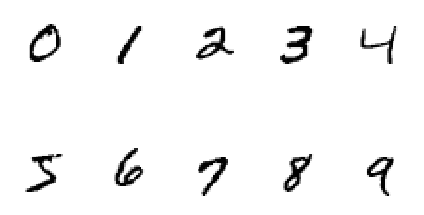

In [10]:
# Visualize samples digits

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)

ax = ax.flatten()
for i in range(10):
    img = XData[yData == i][0].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


In [11]:
# 

XValid, yValid = XData[50000:,:], yData[50000:]
XTrain, yTrain = XData[:50000,:], yData[:50000]

print('Training: {} {}'.format(XTrain.shape, yTrain.shape))
print('Validation: {} {}'.format(XValid.shape, yValid.shape))
print('Test: {} {}'.format(XTest.shape, yTest.shape))

Training: (50000, 784) (50000,)
Validation: (10000, 784) (10000,)
Test: (10000, 784) (10000,)


In [12]:
# Custom function for generating mini batches of data

def batch_generator(X, y, batch_size = 64, shuffle = False, random_seed = None):
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
        
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i + batch_size, :], y[i: i + batch_size])

The function above will return a generator with a tuple for a match of samples, our X inputs and y labels. We also need to normalize the data by subtracting the means and dividing by the standard deviation as this will likely improve training performance and speed up convergence. 

To accomplish this, we compute the mean of each feature using the training data, and then calculate the standard deviation across all features. The reason for calculating the standard deviation this way, rather than dividing each feature by its own individual standard deviation, is that some features/pixels have a constant value of 255 across all images. This indicates no variation across all samples, and therefore, the standard deviation of those features will be zero, and this would cause a division by zero error. To do this, we can use np.std() without specifying an axis.

In [13]:
mean_vals = np.mean(XTrain, axis = 0)
std_vals = np.std(XTrain)

XTrainCent = (XTrain - mean_vals) / std_vals
XValidCent = (XValid - mean_vals) / std_vals
XTestCent = (XTest - mean_vals) / std_vals

<a id = 'Implementing-a-CNN-in-the-TensorFlow-low-level-API'></a>

## Implementing a CNN in the TensorFlow low-level API


In [14]:
import tensorflow as tf

In [15]:
# wrapper function for performing convolution

def conv_layer(input_tensor, name, kernel_size, n_output_channels
               , padding_mode = 'SAME', strides = (1,1,1,1)):
    """
    input_tensor: tensor given as input into the convolutional layer
    name: name of the layer, used to set scope
    kernel_size: dimensions of the kernel tensor, provided as a tuple or list
    n_output_channels: number of output feature maps
    """
    with tf.variable_scope(name):
        # get n_input_channels: input tensor shape: [batch size x width x height x channels_in]
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1]
        
        weights_shape = list(kernel_size) + [n_input_channels, n_output_channels]
        weights = tf.get_variable(name = '_weights', shape = weights_shape)
        print(weights)
        
        biases = tf.get_variable(name = '_biases', initializer = tf.zeros(shape = [n_output_channels]))
        print(biases)
        
        conv = tf.nn.conv2d(input = input_tensor, filter = weights, strides = strides, padding = padding_mode)
        print(conv)
        
        conv = tf.nn.bias_add(conv, biases, name = 'bias_activation')
        print(conv)
        
        conv = tf.nn.relu(conv, name = 'activation')
        print(conv)
        
        return conv


> Remarks - The weights are initialized using Xavier/Glorot intitialization by default, whereas the biases are initialized to the zero. The net pre-activations are passed to ReLU for activation

In [16]:
# Test convolution wrapper function

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])
    conv_layer(x, name = 'convtest', kernel_size = (3,3), n_output_channels = 32)
del g, x


<tf.Variable 'convtest/_weights:0' shape=(3, 3, 1, 32) dtype=float32_ref>
<tf.Variable 'convtest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("convtest/Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/bias_activation:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/activation:0", shape=(?, 28, 28, 32), dtype=float32)


In [17]:
# fully connected layer wrapper function

def fc_layer(input_tensor, name, n_output_units, activation_fn = None):
    """
    input_tensor: the input tensor
    name: name of the layer, used to define scope
    n_output_units: number of output units
    """
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, shape = (-1, n_input_units))
            
        weights_shape = [n_input_units, n_output_units]
        weights = tf.get_variable(name = '_weights', shape = weights_shape)
        print(weights)
        
        biases = tf.get_variable(name = '_biases', initializer = tf.zeros(shape = [n_output_units]))
        print(biases)
        
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        
        layer = tf.nn.bias_add(layer, biases, name = 'net_pre-activation')
        print(layer)
        
        if activation_fn is None:
            return layer
        
        layer = activation_fn(layer, name = 'activation')
        print(layer)
        return layer
    

In [18]:
# test full connected layer wrapper function

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])
    fc_layer(x, name = 'fctest', n_output_units = 32, activation_fn = tf.nn.relu)
del g, x

<tf.Variable 'fctest/_weights:0' shape=(784, 32) dtype=float32_ref>
<tf.Variable 'fctest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("fctest/MatMul:0", shape=(?, 32), dtype=float32)
Tensor("fctest/net_pre-activation:0", shape=(?, 32), dtype=float32)
Tensor("fctest/activation:0", shape=(?, 32), dtype=float32)


> Remarks - The way this wrapper function is utilized will be different for each of the two fully connected layer. the first fully connected layer gets its input right after a convolutional layer, so the input is still a four-dimensional tensor. The second fully connected layer requires that the input tensor be flattened, which we accomplish using the tf.reshape function. (my note - I wonder if this is reversed. I would think the 4D tensor approaching the first fully connected layer would need to be flattened, and this would be caught by the condtional evaluating the length of the input shape)

> Also, the net pre-activations from the first fully connected layer are passed to the ReLU activation function, whereas the second corresponds to the logits, so we use a lienar activation here.

In [19]:
# Build CNN

def build_cnn():
    # placeholders for X and y
    tf_x = tf.placeholder(tf.float32, shape = [None, 784], name = 'tf_x')
    tf_y = tf.placeholder(tf.int32, shape = [None], name = 'tf_y')
    
    # reshape x to a 4D tensor, [batch x width x height, 1]
    tf_x_image = tf.reshape(tf_x, shape = [-1, 28, 28, 1], name = 'tf_x_reshaped')
    
    # one-hot encoding
    tf_y_onehot = tf.one_hot(indices = tf_y, depth = 10, dtype = tf.float32, name = 'tf_y_onehot')
    
    ## Build model
    # 1st layer - conv 1
    print('\nBuilding 1st layer:\n')
    h1 = conv_layer(tf_x_image, name = 'conv_1', kernel_size = (5,5), padding_mode = 'VALID', n_output_channels = 32)
    
    # max pooling
    h1_pool = tf.nn.max_pool(h1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    # 2nd layer - 
    print('\nBuilding 2nd layer:\n')
    h2 = conv_layer(h1_pool, name = 'conv_2', kernel_size = (5,5), padding_mode = 'VALID', n_output_channels = 64)
    
    # max pooling
    h2_pool = tf.nn.max_pool(h2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    # 3rd layer - 
    print('\nBuilding 3rd layer:\n')
    h3 = fc_layer(h2_pool, name = 'fc_3', n_output_units = 1024, activation_fn = tf.nn.relu)
    
    # dropout
    keep_prob = tf.placeholder(tf.float32, name = 'fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob = keep_prob, name = 'dropout_layer')
    
    # 4th layer: fully connected (linear activation)
    print('\nBuilding 4th layer:\n')
    h4 = fc_layer(h3_drop, name = 'fc_4', n_output_units = 10, activation_fn = None)
    
    
    ## prediction
    predictions = {
        'probabilities' : tf.nn.softmax(h4, name = 'probabilities')
        ,'labels' : tf.cast(tf.argmax(h4, axis = 1), tf.int32, name = 'labels')
    }
    
    ## visualize with TensorBoard
    
    # loss function an optimization
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                        logits = h4, labels = tf_y_onehot)
                                    ,name = 'cross_entropy_loss')
    
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss, name = 'train_op')
    
    # computing the prediction accuracy
    correct_predictions = tf.equal(predictions['labels'], tf_y, name = 'correct_preds')
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name = 'accuracy')
    

In [20]:
# utility functions 

def save(saver, sess, epoch, path = './ch15_files/model'):
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in {}'.format(path))
    saver.save(sess, os.path.join(path, 'cnn-model.ckpt'), global_step = epoch)
    
def load(saver, sess, path, epoch):
    print('Loading model from {}'.format(path))
    saver.restore(sess, os.path.join(path, 'cnn-model.ckpt-{}'.format(epoch)))
    
def train(sess, training_set, validation_set = None, initialize = True, epochs = 20, shuffle = True
          , dropout = 0.5, random_seed = None):
    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss = []
    
    # initialize variables
    if initialize:
        sess.run(tf.global_variables_initializer())
        
    np.random.seed(random_seed) # for batch generator shuffling
    for epoch in range(1, epochs + 1):
        batch_gen = batch_generator(X_data, y_data, shuffle = shuffle)
        avg_loss = 0.0
        for i, (batch_x, batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0' : batch_x
                   ,'tf_y:0' : batch_y
                   ,'fc_keep_prob:0' : dropout}
            loss, _ = sess.run(['cross_entropy_loss:0', 'train_op'], feed_dict = feed)
            avg_loss += loss
            
        training_loss.append(avg_loss / (i+1))
        print('Epoch {:2d} training average loss: {:.3f}'.format(epoch, avg_loss), end = ' ')
        
        if validation_set is not None:
            feed = {'tf_x:0' : validation_set[0]
                   ,'tf_y:0' : validation_set[1]
                   ,'fc_keep_prob:0' : 1.0}
            valid_acc = sess.run('accuracy:0', feed_dict = feed)
            print('Validation accuracy: {:.3f}'.format(valid_acc))
        else:
            print()
            
def predict(sess, X_test, return_proba = False):
    feed = {'tf_x:0': X_test
           ,'fc_keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict = feed)
    else:
        return sess.run('labels:0', feed_dict = feed)

In [21]:
# build graph object, set graph-level random seed, construct model

learning_rate = 1e-4
random_seed = 123

# create graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    
    # build graph
    build_cnn()
    
    # saver
    saver = tf.train.Saver()



Building 1st layer:

<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/bias_activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer:

<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/bias_activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:

<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32)
Ten

The next step is the train the CNN model. First, we need to create a TensorFlow session to launch the graph, then we call the train funciton. We also need ot initialize all the variables in the network. This initialization is handled by the 'train' function define above and is handled by the 'initialize' parameter. If this is true, the tf.global_variables_initializer() is run. This step should be avoided if we want to train an existing model for additional epochs because we can restore a previously trained model and complete further training.

In [22]:
# first execution

with tf.Session(graph = g) as sess:
    train(sess, training_set = (XTrainCent, yTrain), validation_set = (XValidCent, yValid)
         ,initialize = True, random_seed = 123)
    save(saver, sess, epoch = 20)

Epoch  1 training average loss: 275.314 Validation accuracy: 0.975
Epoch  2 training average loss: 74.929 Validation accuracy: 0.983
Epoch  3 training average loss: 50.334 Validation accuracy: 0.985
Epoch  4 training average loss: 39.674 Validation accuracy: 0.988
Epoch  5 training average loss: 33.118 Validation accuracy: 0.988
Epoch  6 training average loss: 27.271 Validation accuracy: 0.989
Epoch  7 training average loss: 22.598 Validation accuracy: 0.990
Epoch  8 training average loss: 19.309 Validation accuracy: 0.989
Epoch  9 training average loss: 17.130 Validation accuracy: 0.989
Epoch 10 training average loss: 15.425 Validation accuracy: 0.989
Epoch 11 training average loss: 12.414 Validation accuracy: 0.992
Epoch 12 training average loss: 11.617 Validation accuracy: 0.991
Epoch 13 training average loss: 10.696 Validation accuracy: 0.992
Epoch 14 training average loss: 8.640 Validation accuracy: 0.991
Epoch 15 training average loss: 8.464 Validation accuracy: 0.992
Epoch 16 tr

In [23]:
# restore saved model by deleting existing graph g
# then create a new graph g2, and reload the trained model 
# to perform predictions on the test set

del g

# create enw graph and build model
g2 = tf.Graph()
with g2.as_default():
    tf.set_random_seed(random_seed)
    build_cnn()
    saver = tf.train.Saver()

# create a new session and restore model
with tf.Session(graph = g2) as sess:
    load(saver, sess, epoch = 20, path = './ch15_files/model/')
    preds = predict(sess, XTestCent, return_proba = False)
    print('Test accuracy: {}'.format(np.sum(preds == yTest) / len(yTest)))


Building 1st layer:

<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/bias_activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer:

<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/bias_activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:

<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32)
Ten

> Remarks - Better prediction accuracy than what was achieved using the MLP in chapter 13

In [24]:
# Review predicted labels and probabilities on first 10 test samples

with tf.Session(graph = g2) as sess:
    load(saver, sess, epoch = 20, path = './ch15_files/model/')
    print(predict(sess, XTestCent[:10], return_proba = False))
    print(predict(sess, XTestCent[:10], return_proba = True))

Loading model from ./ch15_files/model/
INFO:tensorflow:Restoring parameters from ./ch15_files/model/cnn-model.ckpt-20
[7 2 1 0 4 1 4 9 5 9]
[[0.         0.         0.         0.00000015 0.         0.
  0.         0.99999976 0.         0.00000011]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00000003 0.99989974 0.00000003 0.         0.00000947 0.00000002
  0.00000003 0.00009042 0.00000029 0.00000001]
 [0.99999905 0.         0.         0.         0.         0.
  0.00000096 0.         0.         0.00000001]
 [0.         0.         0.         0.         0.9999988  0.
  0.         0.         0.         0.00000123]
 [0.         0.9999974  0.         0.         0.00000008 0.
  0.         0.00000245 0.         0.        ]
 [0.         0.00000012 0.         0.         0.998738   0.
  0.         0.00000014 0.00117239 0.00008942]
 [0.         0.         0.00000004 0.00000004 0.00000041 0.00000001
  0.         0.         0.00000014 

In [26]:
# Train the model another 20 epochs
# Be sure to set initialize = False

with tf.Session(graph = g2) as sess:
    load(saver, sess, epoch = 20, path = './ch15_files/model/')
    train(sess, training_set = (XTrainCent, yTrain), validation_set = (XValidCent, yValid), initialize = False
         ,epochs = 20, random_seed = 123)
    save(saver, sess, epoch = 40, path = './ch15_files/model/')
    
    preds = predict(sess, XTestCent, return_proba = False)
    print('Test accuracy: {}'.format(np.sum(preds == yTest) / len(yTest)))

Loading model from ./ch15_files/model/
INFO:tensorflow:Restoring parameters from ./ch15_files/model/cnn-model.ckpt-20
Epoch  1 training average loss: 4.383 Validation accuracy: 0.992
Epoch  2 training average loss: 3.730 Validation accuracy: 0.991
Epoch  3 training average loss: 3.794 Validation accuracy: 0.991
Epoch  4 training average loss: 3.733 Validation accuracy: 0.992
Epoch  5 training average loss: 2.937 Validation accuracy: 0.992
Epoch  6 training average loss: 3.028 Validation accuracy: 0.993
Epoch  7 training average loss: 2.902 Validation accuracy: 0.992
Epoch  8 training average loss: 2.531 Validation accuracy: 0.992
Epoch  9 training average loss: 2.793 Validation accuracy: 0.993
Epoch 10 training average loss: 2.931 Validation accuracy: 0.993
Epoch 11 training average loss: 2.302 Validation accuracy: 0.993
Epoch 12 training average loss: 1.964 Validation accuracy: 0.992
Epoch 13 training average loss: 2.060 Validation accuracy: 0.992
Epoch 14 training average loss: 2.447

> Remarks - Another 20 epochs shows a net decrease in training loss, steady performance on the validation data, and similar results on the test set.

<a id = 'Implementing-a-CNN-in-the-TensorFlow-Layers-API'></a>

# Implementing a CNN in the TensorFlow Layers API

In [48]:
# 

class ConvNN(object):
    def __init__(self, batchsize = 64, epochs = 20, learning_rate = 1e-4, dropout_rate = 0.5
                ,shuffle = True, random_seed = None):
        np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
        
        g = tf.Graph()
        with g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
        
        # create a session
        self.sess = tf.Session(graph = g)
    
    def build(self):
        tf_x = tf.placeholder(tf.float32, shape = [None, 784], name = 'tf_x')
        tf_y = tf.placeholder(tf.int32, shape = [None], name = 'tf_y')        
        is_train = tf.placeholder(tf.bool, shape = (), name = 'is_train')
        
        # reshape x to a 4D tensor, [batch x width x height x 1]
        tf_x_image = tf.reshape(tf_x, shape = [-1, 28, 28, 1], name = 'input_x_2dimages')
        
        # one hot encoding
        tf_y_onehot = tf.one_hot(indices = tf_y, depth = 10, dtype = tf.float32, name = 'input_y_onehot')
        
        ## build model
        # 1st layer - conv
        h1 = tf.layers.conv2d(tf_x_image, kernel_size = (5,5), filters = 32, activation = tf.nn.relu)
        
        # max pooling
        h1_pool = tf.layers.max_pooling2d(h1, pool_size = (2,2), strides = (2,2))
        
        # 2nd layer - conv
        h2 = tf.layers.conv2d(h1_pool, kernel_size = (5,5), filters = 64, activation = tf.nn.relu)
        
        # max pooling
        h2_pool = tf.layers.max_pooling2d(h2, pool_size = (2,2), strides = (2,2))
        
        # 3rd layer - fully connected
        input_shape = h2_pool.get_shape().as_list()
        n_input_units = np.prod(input_shape[1:])
        h2_pool_flat = tf.reshape(h2_pool, shape = [-1, n_input_units])
        h3 = tf.layers.dense(h2_pool_flat, 1024, activation = tf.nn.relu)
        
        # dropout
        h3_drop = tf.layers.dropout(h3, rate = self.dropout_rate, training = is_train)
        
        # 4th layer = fully connected w/ linear activation
        h4 = tf.layers.dense(h3_drop, 10, activation = None)
        
        ## prediction
        predictions = {
            'probabilities' : tf.nn.softmax(h4, name = 'probabilities')
            ,'labels' : tf.cast(tf.argmax(h4, axis = 1), tf.int32, name = 'labels')
        }

        ## visualize with TensorBoard

        # loss function an optimization
        cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                                            logits = h4, labels = tf_y_onehot)
                                        ,name = 'cross_entropy_loss')

        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss, name = 'train_op')
        
        ## find accuracy
        correct_predictions = tf.equal(predictions['labels'], tf_y, name = 'correct_preds')
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name = 'accuracy')
        
    def save(self, epoch, path = './ch15_files/layers'):
        if not os.path.isdir(path):
            os.makedirs(path)
        print('Saving model in {}'.format(path))
        saver.save(self.sess, os.path.join(path, 'cnn-model.ckpt'), global_step = epoch)

    def load(self, path, epoch):
        print('Loading model from {}'.format(path))
        saver.restore(self.sess, os.path.join(path, 'cnn-model.ckpt-{}'.format(epoch)))

    def train(self, training_set, validation_set = None, initialize = True):
        # initialize variables
        if initialize:
            self.sess.run(self.init_op)
        
        self.train_cost_ = []
        X_data = np.array(training_set[0])
        y_data = np.array(training_set[1])
                
        for epoch in range(1, self.epochs + 1):
            batch_gen = batch_generator(X_data, y_data, shuffle = self.shuffle)
            avg_loss = 0.0
            for i, (batch_x, batch_y) in enumerate(batch_gen):
                feed = {'tf_x:0' : batch_x
                       ,'tf_y:0' : batch_y
                       ,'is_train:0' : True} # for dropout
                loss, _ = self.sess.run(['cross_entropy_loss:0', 'train_op'], feed_dict = feed)
                avg_loss += loss

            print('Epoch {:2d} training average loss: {:.3f}'.format(epoch, avg_loss), end = ' ')

            if validation_set is not None:
                feed = {'tf_x:0' : validation_set[0]
                       ,'tf_y:0' : validation_set[1]
                       ,'is_train:0' : False} # for dropout
                valid_acc = self.sess.run('accuracy:0', feed_dict = feed)
                print('Validation accuracy: {:.3f}'.format(valid_acc))
            else:
                print()

    def predict(self, X_test, return_proba = False):
        feed = {'tf_x:0': X_test
               ,'is_train:0': 1.0} # dropout
        if return_proba:
            return self.sess.run('probabilities:0', feed_dict = feed)
        else:
            return self.sess.run('labels:0', feed_dict = feed)

In [42]:
# Create instance of ConvNN and train for 20 epochs

cnn = ConvNN(random_seed = 123)

cnn.train(training_set = (XTrainCent, yTrain)
         ,validation_set = (XValidCent, yValid)
         ,initialize = True)
cnn.save(epoch = 20)

Epoch  1 training average loss: 268.286 Validation accuracy: 0.975
Epoch  2 training average loss: 74.677 Validation accuracy: 0.982
Epoch  3 training average loss: 51.023 Validation accuracy: 0.986
Epoch  4 training average loss: 40.015 Validation accuracy: 0.988
Epoch  5 training average loss: 32.514 Validation accuracy: 0.988
Epoch  6 training average loss: 27.176 Validation accuracy: 0.989
Epoch  7 training average loss: 22.949 Validation accuracy: 0.989
Epoch  8 training average loss: 20.074 Validation accuracy: 0.990
Epoch  9 training average loss: 17.111 Validation accuracy: 0.991
Epoch 10 training average loss: 15.907 Validation accuracy: 0.992
Epoch 11 training average loss: 12.695 Validation accuracy: 0.992
Epoch 12 training average loss: 11.601 Validation accuracy: 0.991
Epoch 13 training average loss: 10.880 Validation accuracy: 0.992
Epoch 14 training average loss: 9.702 Validation accuracy: 0.991
Epoch 15 training average loss: 7.632 Validation accuracy: 0.992
Epoch 16 tr

In [49]:
# Use trained model to perform predictions

#del cnn

cnn2 = ConvNN(random_seed = 123)
cnn2.load(epoch = 20, path = './ch15_files/layers')

print(cnn2.predict(XTestCent[:10, :]))


Loading model from ./ch15_files/layers
INFO:tensorflow:Restoring parameters from ./ch15_files/layers/cnn-model.ckpt-20
[7 2 1 0 4 1 4 9 5 9]


In [60]:
# Measure accuracy on test set

preds = cnn2.predict(XTestCent)
print('Test accuracy: {}'.format(np.sum(yTest == preds) / len(yTest)))


Test accuracy: 0.9906
